In [1]:
import json, os, sys, math, time, random

import numpy as np
import matplotlib.pyplot as plt

from utils import *

In [2]:
with open('msd-data/features.json', 'r') as f:
    all_features = json.load(f)

In [4]:
# Computes approximate sinusoity between the straight line from source to target and the actual path
# https://en.wikipedia.org/wiki/Sinuosity
def sinusoity(straight_line_distance: float, path: list[str], source: str, dest: str, distance_function):
    total_distance = 0
    path = [source, *path, dest]

    for i in range(len(path) - 1):
        start_feats = all_features[path[i]]
        end_feats = all_features[path[i+1]]
        
        total_distance += distance_function(start_feats, end_feats)
    
    return total_distance / straight_line_distance

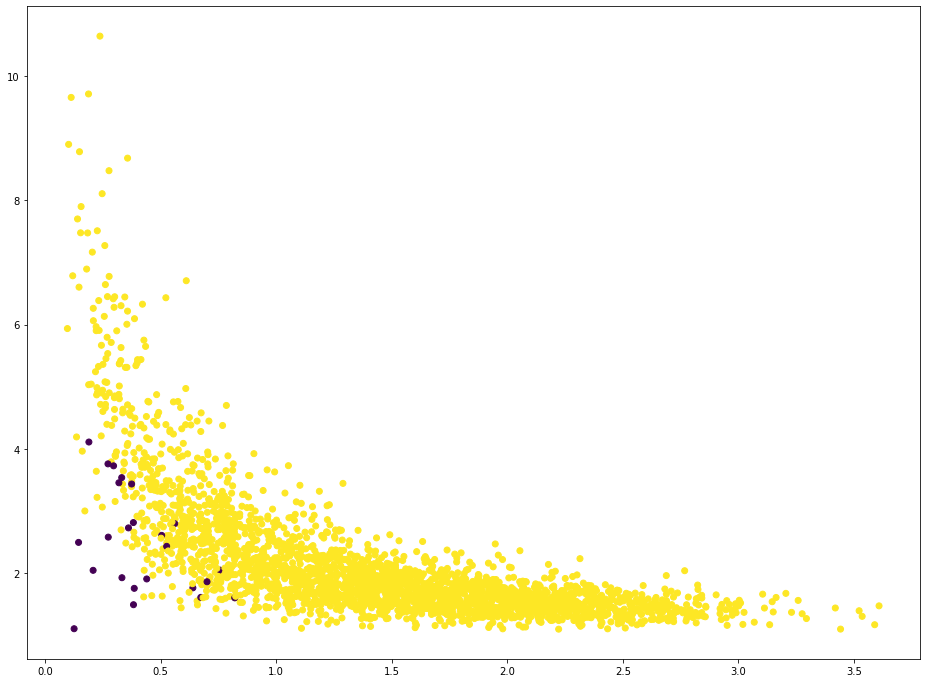

In [24]:
def scatter_plot_results(RESULTS: str, distance_function):
    result_set = {}

    for result in os.listdir(RESULTS):
        with open(f'{RESULTS}/{result}') as f:
            res_data = json.load(f)
            if res_data['PATH']:
                result_set[result.strip('.json')] = res_data

    num_points = len(result_set)
    plot_points = np.empty(shape=(num_points, 3)) # n x 3 array containing (x, y, color)

    for i, result in enumerate(result_set.values()):
        straight_line_distance = distance_function(result['SOURCE_FEATS'], result['TARGET_FEATS'])
        sins = sinusoity(straight_line_distance, result['PATH'], result['meta']['SOURCE_ID'], result['meta']['TARGET_ID'])

        plot_points[i] = [straight_line_distance, sins, 0 if result['meta']['FOUND'] else 180]

    # Filter outliers in terms of sinusoity
    std_range = 4
    sinusoity_std = np.std(plot_points[:, 1])
    sinusoity_mean = np.mean(plot_points[:, 1])
    plot_points = plot_points[abs(plot_points[:, 1] - sinusoity_mean) < std_range * sinusoity_mean]

    plt.figure(figsize=(16, 12))
    plt.scatter(plot_points[:, 0], plot_points[:, 1], c=plot_points[:, 2])
    plt.show()

RESULTS = 'msd-results/results-n=10-d=1000-l=1'
distance_function = feature_distance_l1
scatter_plot_results(RESULTS, distance_function)

In [10]:
for i, result in enumerate(result_set.values()):
    straight_line_distance = distance_function(result['SOURCE_FEATS'], result['TARGET_FEATS'])
    sins = sinusoity(straight_line_distance, result['PATH'], result['meta']['SOURCE_ID'], result['meta']['TARGET_ID'])

    plot_points[i] = [straight_line_distance, sins, 0 if result['meta']['FOUND'] else 180]

In [22]:
# Filter outliers in terms of sinusoity
std_range = 4
sinusoity_std = np.std(plot_points[:, 1])
sinusoity_mean = np.mean(plot_points[:, 1])
plot_points = plot_points[abs(plot_points[:, 1] - sinusoity_mean) < std_range * sinusoity_mean]
# abs(plot_points[:, 1] - sinusoity_mean) < std_range * sinusoity_mean

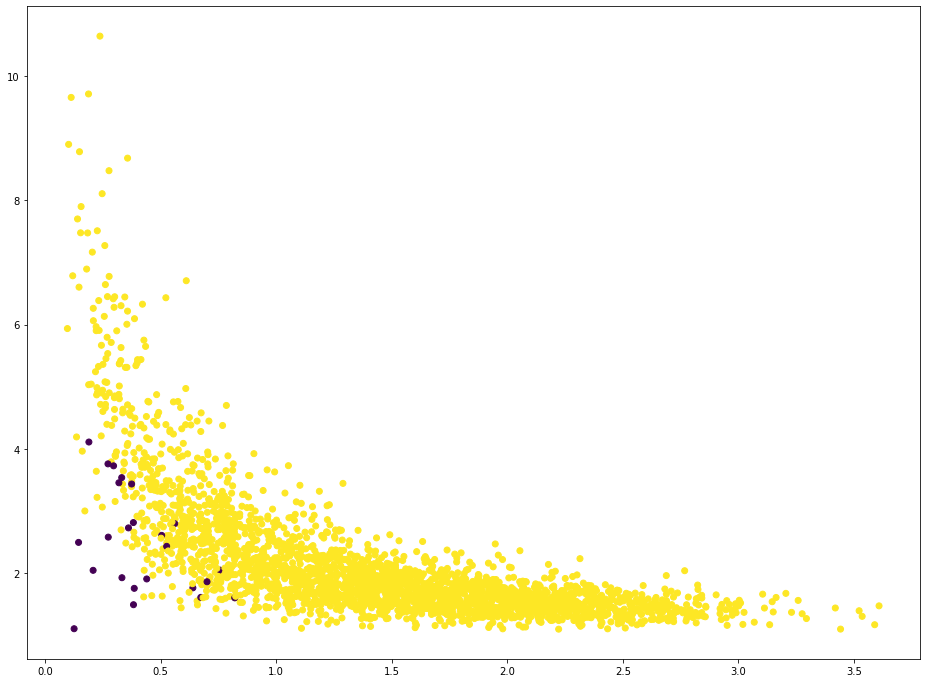

In [23]:
plt.figure(figsize=(16, 12))
plt.scatter(plot_points[:, 0], plot_points[:, 1], c=plot_points[:, 2])
plt.show()